In [286]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import joblib
import os

from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.model_selection import KFold,GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

In [287]:
dataset_path = "mobile phone price prediction.csv"
random_state = 29
K_cv = [8]
polynom_degree = [1,2,3]
alpha_values = [0.01,0.05,0.1,0.2,0.5,1,2,5,10,11,12,13,14,15,18,20]
max_iterations = [10000, 20000, 30000, 40000, 50000]
tolerance = [1, 1e-1, 1e-2, 1e-3]

feature_scaler = StandardScaler()
polynomial_feature_scaler = PolynomialFeatures()

models = {
    "Linear":LinearRegression(), # Linear Regression
    "Lasso":Lasso(), # L1 Regression
    "Ridge":Ridge() # L2 Regression
}

param_grids = {
    "Linear": {
        "poly__degree": polynom_degree,  # Adjust the degrees of PolynomialFeatures
        "model__fit_intercept": [True, False],  # Example of a parameter for LinearRegression
    },
    "Lasso": {
        "model__alpha": alpha_values,
        "model__max_iter": max_iterations,
        "model__tol": tolerance
    },
    "Ridge": {
        "model__alpha": alpha_values,
        "model__max_iter": max_iterations,
        "model__solver": ["auto", "saga"],
        "model__tol": tolerance
    }
}

In [288]:
dataset_original = pd.read_csv(dataset_path)
length_dataset = len(dataset_original)
#print(dataset_original.info())
#print(dataset_original.head(3))

# renaming so all columns start with Capital letter
dataset_original.rename(columns={'Processor': 'Processor_core','company':'Company','fast_charging':'Fast_charging'},inplace=True)

## CHOSING WHICH COLUMNS ARE THE BEST FOR OUR PRICE PREDICTIONS

In [289]:
categorical_columns = ["Processor_core" , "Company" , "Processor_name"]
numerical_columns = ["Ram" , "Battery" , "Display" , "Android_version" , "Inbuilt_memory" , "Fast_charging", "Camera"]
target_column = ["Price"]

In [290]:
# function to remove outliers using our knowledge 
# it means for example RAM column should have values between 2 and 16 for example , LIKE WE KNOW THIS IN REAL LIFE ( OUR REAL LIFE KNOWLEDGE )
def remove_outliers_with_domain_knowledge(df, lower_bound, upper_bound):
    """
    Removing outliers with our real life knowledge on the topic
    
    Args:
        df: The Target Dataframe.
        lower_bound: Lowest values for our features.
        upper_bound: Highest values for our features.
    
    Returns:
        A Dataframe with clipped borders thus no extreme values, without the outliers.
    """
    df_cleaned = df.copy()
    for idx, col in enumerate(numerical_columns + target_column):
        #print(f"Before: Min = {df[col].min()}, Max = {df[col].max()}")
        # REMOVING VALUES THAT ARE LOWER OR BIGGER THE THE BOUNDS
        df_cleaned[col] = df[col].clip(lower=lower_bound[idx], upper=upper_bound[idx])
        #print(f"After: Min = {df_cleaned[col].min()}, Max = {df_cleaned[col].max()}")
        
    return df_cleaned

In [291]:
def box_plot_visualization(df,state):
    """
    Box plot visualization 
    
    Args:
        df: The Target Dataframe.
        state: State of our df, 'before or after'
    
    Returns:
        
    """
    columns = numerical_columns + target_column

    # Set the number of columns for each row (in this case, 2)
    num_columns = 2
    num_rows = (len(columns) + 1) // num_columns  # Calculate the number of rows needed

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))
    
    # Flatten the axes array for easier iteration
    axes = axes.flatten()
    
    # Plot each histogram on the corresponding subplot
    for idx, col in enumerate(columns):
        sns.boxplot(x=df[col],ax=axes[idx])
        axes[idx].set_title(f"{col} State: {state} Boxplot")
        
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

In [292]:
def hist_plot_visualization(df):
    """
    Histograme plot visualization 
    
    Args:
        df: The Target Dataframe.

    Returns:
        
    """
    # Combine numerical columns and target column
    columns = numerical_columns + target_column

    # Set the number of columns for each row (in this case, 2)
    num_columns = 2
    num_rows = (len(columns) + 1) // num_columns  # Calculate the number of rows needed

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))
    
    # Flatten the axes array for easier iteration
    axes = axes.flatten()

    # Plot each histogram on the corresponding subplot
    for idx, col in enumerate(columns):
        sns.histplot(df[col], kde=True, bins=30, ax=axes[idx])
        axes[idx].set_title(f"{col} : Capacity Distribution")
        
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

In [293]:
def heatmap_visualization(df):
    """
    Heatmap, Correlation plot visualization 
    
    Args:
        df: The Target Dataframe.

    Returns:
    
    """
    correlation_matrix = df[numerical_columns+target_column].corr()
    # Plot the correlation heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Feature Correlation Matrix')
    plt.show()

In [294]:
def feature_importance_visualization(X,y):
    """
    Feature importance visualization
    
    Args:
        X: Our Features.
        y: Target Feature.

    Returns:
    
    """
    importance = mutual_info_regression(X, y.values.ravel())

    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importance
    })

    # Sort features by importance
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(12, 10))
    sns.barplot(
        data=feature_importance, 
        x='Importance', 
        y='Feature', 
        hue='Feature',  # Assign the `y` variable (Feature) to `hue`
        dodge=False,    # Ensure no separation by hue
        palette='viridis'
    )
    plt.title('Feature Importance Based on Mutual Information')
    plt.xlabel('Mutual Information Score')
    plt.ylabel('Features')
    plt.show()


In [295]:
def train_evaluate_with_gridsearch(X, y, models, param_grids):
    """
    Train and evaluate models using GridSearchCV for hyperparameter tuning.
    
    Args:
        X: Features dataframe.
        y: Target dataframe.
        models: Dictionary of model names and their initialized estimators.
        param_grids: Dictionary of model names and their hyperparameter grids.
    
    Returns:
        A DataFrame with results for each model and hyperparameter combination.
    """
    results = []
    for name, model in models.items():
        for k_split in K_cv:
            param_grid = param_grids[name]
            # Create the preprocessing pipeline to include features scaling
            if 'Linear' in name:
                pipeline = Pipeline([
                ("poly", polynomial_feature_scaler),
                ("scaler", feature_scaler),
                ("model", model)
                ])
            else:
                pipeline = Pipeline([
                    ("scaler", feature_scaler),
                    ("model", model)
                ])
            
            # GridSearchCV setup
            grid_search = GridSearchCV(
                estimator=pipeline,
                param_grid=param_grid,
                scoring="r2",  # Multiple scoring metrics
                refit="r2",  # Choose the best model based on R2
                cv=KFold(n_splits=k_split, shuffle=True, random_state=random_state),  # Cross-validation splits
                n_jobs=-1  # Parallelize for faster execution
            )

            begin_train_time = time.time()
            # Train GridSearchCV
            grid_search.fit(X, y)
            end_train_time = time.time()
            
            results.append({
                "model_name": name,
                "model": grid_search.best_estimator_,
                "K_cv": k_split,
                "best_params": grid_search.best_params_,
                "best_r2": grid_search.best_score_,  # Negate since MSE is negative
                "train_time": end_train_time - begin_train_time
            })
            
    #fitted_scaler = grid_search.best_estimator_.named_steps['scaler']
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    return results_df

In [296]:
def predict_price(input_data, real_prices, model, X, lower_bound, upper_bound):
    """
    Train and evaluate models using GridSearchCV for hyperparameter tuning.
    
    Args:
        input_data: Input Dataframe.
        real_prices: Real prices list that corresponds to our input_data.
        model: Dictionary of best model name and it initialized estimators.
        X: Features dataframe.
        lower_bound: Lowest values for our features.
        upper_bound: Highest values for our features.
    
    Returns:
        
    """
    input_data_encoded = pd.get_dummies(input_data, columns=categorical_columns)
    input_data_encoded = input_data_encoded.reindex(columns=X.columns, fill_value=0)

    prediction = model.predict(input_data_encoded)
    # Clip to bounds
    prediction = np.clip(prediction, lower_bound[-1], upper_bound[-1])

    for idx, pred in enumerate(prediction):
        #print(f"Type of prediction: {type(pred)}, Value: {pred}")
        print(f"The predicted price of the phone is: {pred.item():.2f}")
        print(f"Difference in price: {int(pred.item()) - real_prices[idx]}")

In [297]:
def save_model(model,want_save):
    """
    Saving Model Based on Condition.
    
    Args:
        model: Dictionary of best model name and it initialized estimators.
        want_save : Boolean to confirm the saving process.
    Returns:
        
    """
    if not want_save:
        return
    model_filename = f"{model['model_name']}_model_k{model['K_cv']}_r2_{model['best_r2']:.3f}.joblib"
    joblib.dump(model['model'], model_filename)
    print(f"Model saved as: {model_filename}")

## DROPING COLUMNS THAT ARE NOT SUITED FOR OUR PREDICTIONS

In [298]:
for col in dataset_original.columns:
    if col not in categorical_columns+numerical_columns+target_column:
        dataset_original.drop(col,axis=1,inplace=True)
        
dataset_original.drop_duplicates(inplace=True)
dataset_original.dropna(axis=0,how='all',inplace=True)

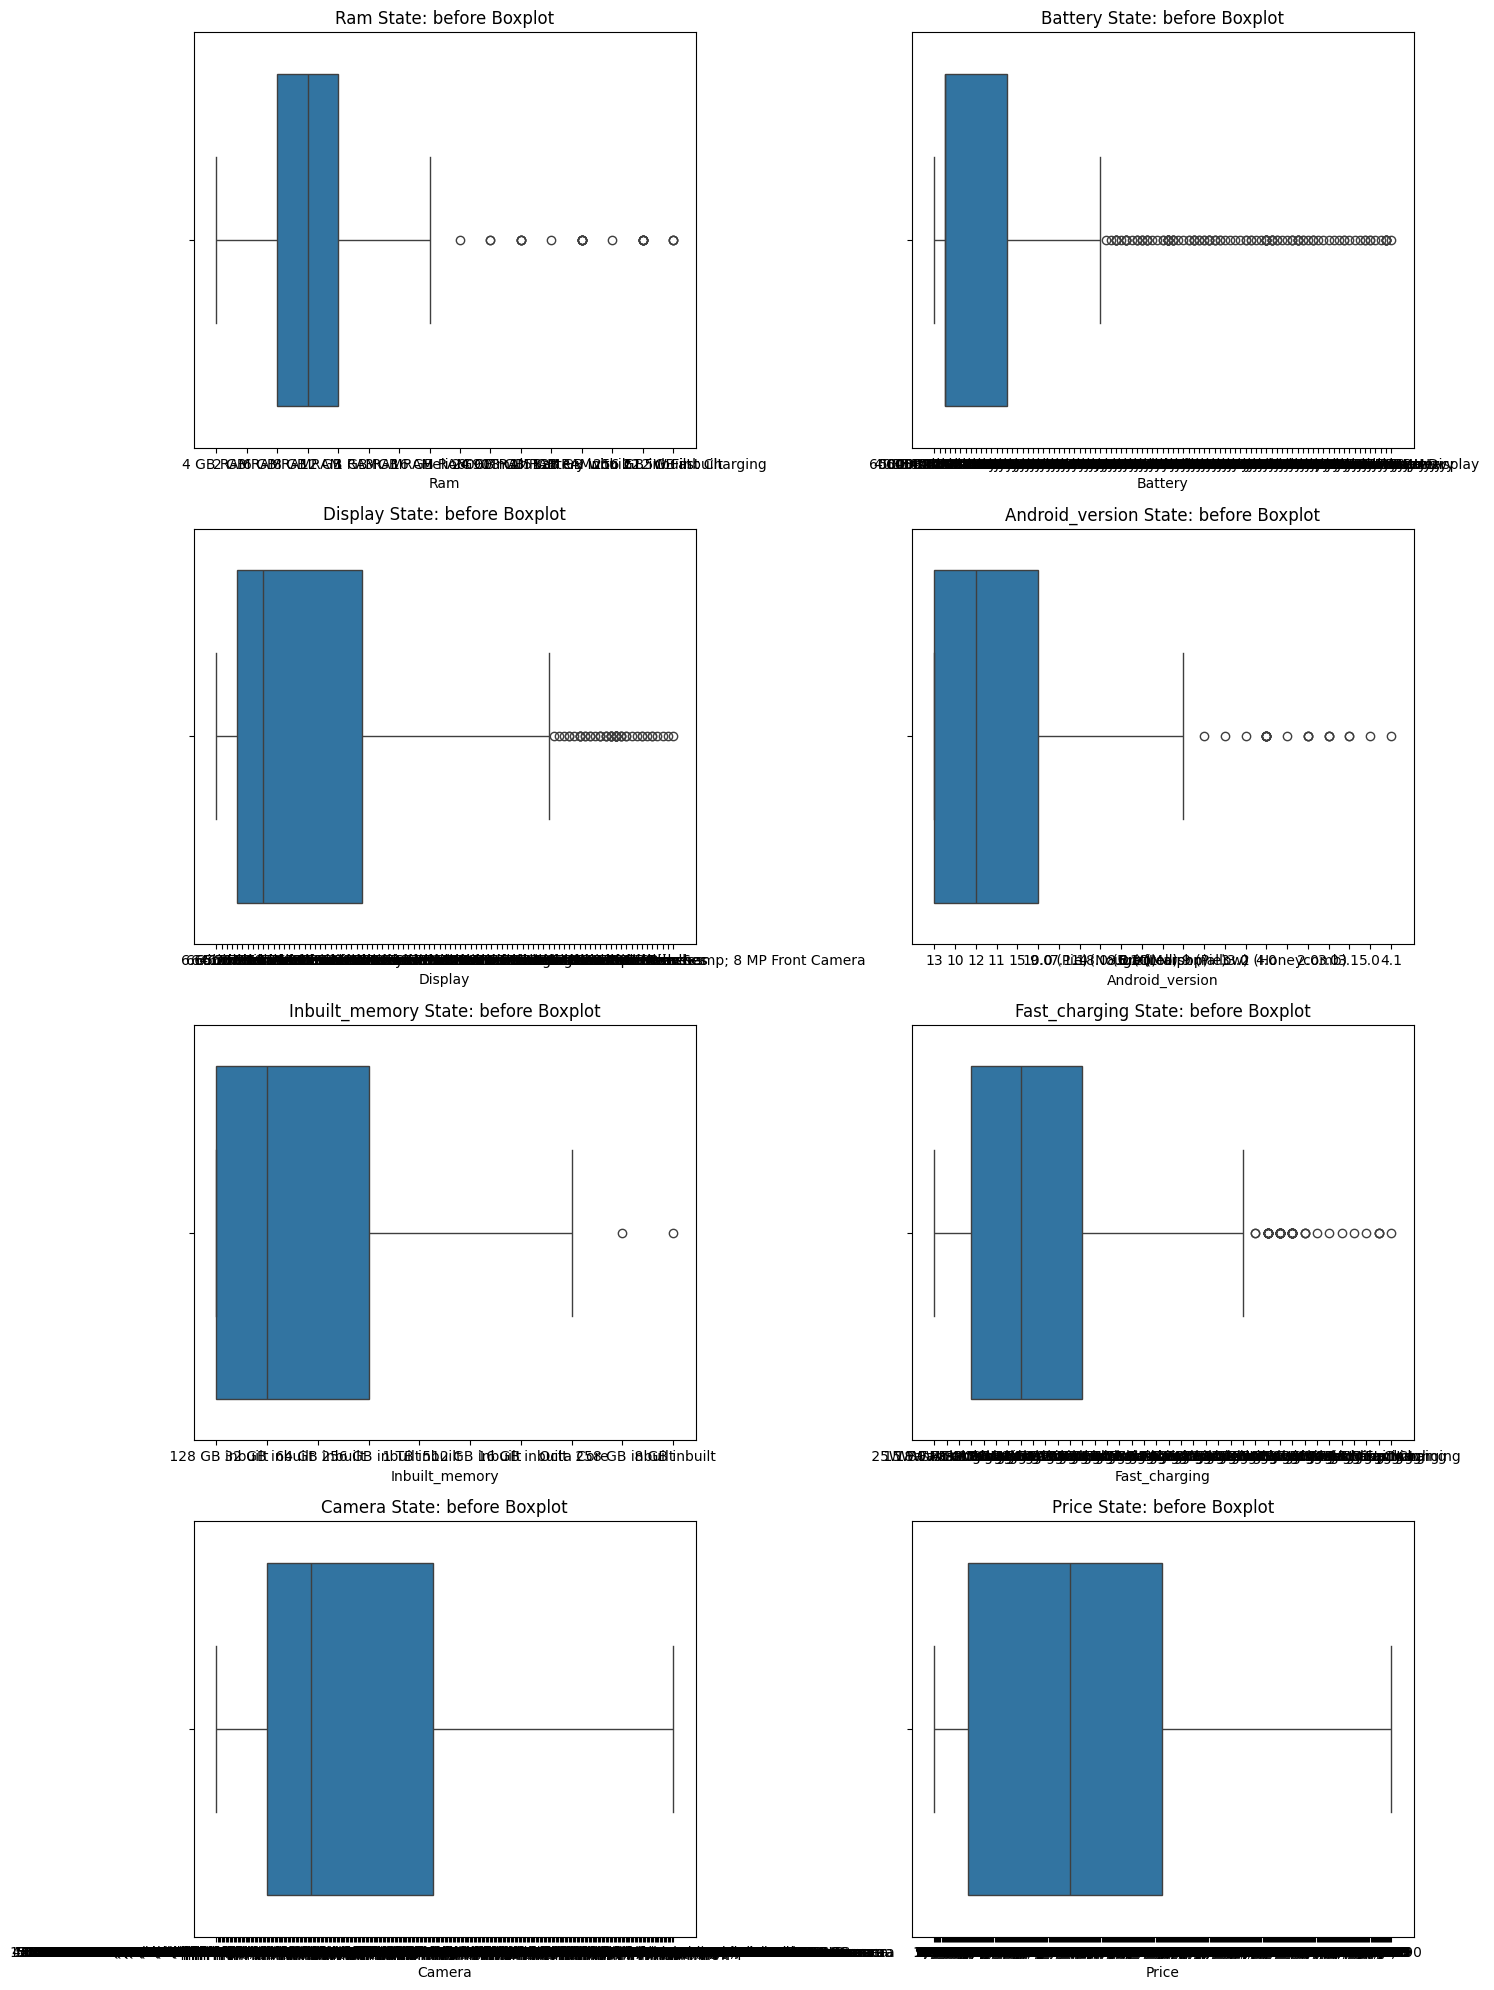

In [299]:
box_plot_visualization(dataset_original,'before')

# STANDARIZING THE DATA

### HERE I CHOSE WHICH DATA TO KEEP AND TO REPLACE BASED ON .unique() method , i didnt want to include it here cause of too much print() statements

## FOR CATEGORICAL DATA

In [300]:
dataset_original["Processor_core"] = dataset_original["Processor_core"].str.strip()
dataset_original.loc[dataset_original["Processor_core"].str.contains(r'\d+\.?\d*',regex=True,na=False), "Processor_core"] = np.nan
dataset_original["Processor_core"].replace({
    'Octa Core Processor': 'Octa Core',
    'Nine-Cores': 'Nine Core',
    'Nine Cores': 'Nine Core',
    'Deca Core Processor': 'Deca Core'
},regex=False,inplace=True)

In [301]:
dataset_original["Company"] = dataset_original["Company"].astype(str)
dataset_original["Company"].replace("Nothing",np.nan,regex=False,inplace=True)

In [302]:
dataset_original["Processor_name"] = dataset_original["Processor_name"].astype(str)

dataset_original.loc[dataset_original["Processor_name"].str.contains(r'Core|Wifi|GB', na=False, case=False,regex=True), "Processor_name"] = np.nan
dataset_original.loc[dataset_original["Processor_name"].str.contains("Samsung", na=False, case=False), "Processor_name"] = "Exynos"
dataset_original.loc[dataset_original["Processor_name"].str.contains(r"Sanpdragon|Snapdragon",regex=True,na=False, case=False), "Processor_name"] = "Snapdragon"
dataset_original.loc[dataset_original["Processor_name"].str.contains("Dimensity", na=False, case=False), "Processor_name"] = "Dimensity"

dataset_original["Processor_name"].replace(r'\s+\d+\w*|\s+\w+',"",regex=True,inplace=True)
dataset_original["Processor_name"].replace("",np.nan,inplace=True)

## FILLING MISSING VALUES WITH MODE FOR CATEGORICAL DATA

In [303]:
for col in categorical_columns:
    dataset_original[col] = dataset_original[col].str.strip().str.lower()
    print(f"the ratio of nan {col}: {dataset_original[col].isna().sum()*100 / len(dataset_original):.2f}")
    dataset_original[col].fillna(dataset_original[col].mode()[0],inplace=True)
    print(dataset_original[col].unique())

the ratio of nan Processor_core: 2.72
['octa core' 'quad core' 'nine core' 'deca core']
the ratio of nan Company: 1.10
['samsung' 'vivo' 'realme' 'oppo' 'iqoo' 'poco' 'honor' 'google' 'itel'
 'asus' 'lg' 'lenovo' 'gionee' 'motorola' 'oneplus' 'xiaomi' 'tecno'
 'huawei' 'lava' 'coolpad' 'tcl']
the ratio of nan Processor_name: 2.86
['exynos' 'snapdragon' 'helio' 'dimensity' 'unisoc' 'tiger' 'sc9863a'
 'tensor' 'google' 'kirin']


## ONE HOT ENCODING FOR OUR CATEGORICAL DATA

In [304]:
dataset_original = pd.get_dummies(dataset_original, columns=categorical_columns)

## FOR NUMERICAL DATA

In [305]:
dataset_original["Ram"].replace(r"\s*GB\s*RAM", "",regex=True,inplace=True)
dataset_original["Battery"].replace(r"\s*mAh\s*Battery", "",regex=True,inplace=True)
dataset_original["Display"].replace(r"\s*inches", "",regex=True,inplace=True)
dataset_original["Inbuilt_memory"].replace(r"\s*GB\s*inbuilt", "",regex=True,inplace=True)

dataset_original["Fast_charging"] = dataset_original["Fast_charging"].str.extract(r"(\d+\.?\d*)")

dataset_original["Camera"] = dataset_original["Camera"].str.strip().str.lower()
dataset_original.loc[dataset_original["Camera"].str.contains(r'display|memory', case=False, na=False),'Camera'] = np.nan
dataset_original["Camera_rear"] = dataset_original["Camera"].str.extract(r"(\d+)\s*mp")
dataset_original["Camera_front"] = dataset_original["Camera"].str.extract(r";\s*(\d+)\s*mp")
dataset_original.drop("Camera",axis=1,inplace=True)

dataset_original["Price"].replace(',','', regex=True,inplace=True)

In [306]:
# here we remove camera column and change it to new 2 columns ( camera rear and camera front )
numerical_columns.pop()
numerical_columns.extend(["Camera_rear", "Camera_front"])
# regressor columns are columns that we will fill using another model predictions cause these columns have NAN values ratio > 5-30%
# so its better then using mean or median
regressor_columns = ["Android_version","Fast_charging","Camera_rear", "Camera_front"]

### casting the numerical columns to be float using pandas.to_numeric and removing the nan values except for regressor columns

In [307]:
for col in numerical_columns+target_column:
    dataset_original[col] = pd.to_numeric(dataset_original[col],errors='coerce')
    print(f"the ratio of nan {col}: {dataset_original[col].isna().sum()*100 / len(dataset_original):.2f}")
    if col not in regressor_columns:
        dataset_original[col].fillna(dataset_original[col].median(),inplace=True)

the ratio of nan Ram: 1.40
the ratio of nan Battery: 0.15
the ratio of nan Display: 0.15
the ratio of nan Android_version: 34.65
the ratio of nan Inbuilt_memory: 1.76
the ratio of nan Fast_charging: 9.40
the ratio of nan Camera_rear: 5.80
the ratio of nan Camera_front: 6.46
the ratio of nan Price: 0.00


# REMOVING OUTLIERS AFTER GOT DETECTED USING BOX PLOT WITH OUR KNOWLEDGE

In [308]:
# HERE THE COLUMNS ORDER IS :
# Ram , Battery , Display , Android_version , Inbuilt_memory , Fast_charging , Camera_rear, Camera_front , Price
# for example here LOWER BOUND : lowest ram = 2 , lowest battery = 2500 , lowest display = 5.5 ETC
# SAME FOR UPPER BOUND                                 
lower_bound = [2,2500,5.5,8,16,10,5,2,6950]
upper_bound = [16,6500,7.5,14,256,140,80,60,70000]

dataset_cleaned_encoded = remove_outliers_with_domain_knowledge(dataset_original, lower_bound, upper_bound)

# FILLING NAN VALUES FOR THE REGRESSOR COLUMNS WITH ANOTHER MODEL

In [309]:
# MAKING A DATASET FOR ALL COLUMNS EXCEPT THE TARGET COLUMN ( PRICE ) , ITS BETTER SO WE DONT OVERRIDE OUR ORIGINAL DATASET
dataset_for_regressor = dataset_cleaned_encoded[[col for col in dataset_cleaned_encoded.columns if col not in target_column]].copy()
# we use random forest regressor to fill nan values here
regressor = RandomForestRegressor(n_estimators=100,random_state=random_state)

for col in regressor_columns:
    # making train dataset using rows that have NOT NULL values in the regressor column 
    # meaning for example all rows where android_version is not null
    train_dataset_for_regressor = dataset_for_regressor[dataset_for_regressor[col].notna()]
    # making test dataset using rows that have NULL values in the regressor column
    test_dataset_for_regressor = dataset_for_regressor[dataset_for_regressor[col].isna()]

    # we drop the column that we want to predict FROM THE DATASET WHERE col is NOT NULL , means all rows where COL was NOT NULL SO WE COULD MAKE PREDICTIONS
    X_train = train_dataset_for_regressor.drop(columns=col)
    # y is the column that we want to predict FROM THE DATASET WHERE col is NOT NULL , so we could make predictions 
    y_train = train_dataset_for_regressor[col]
    # we drop the column that we want to predict FROM THE DATASET WHERE col is NULL , means all rows where COL was NULL
    X_test = test_dataset_for_regressor.drop(columns=col)

    regressor.fit(X_train,y_train)
    print(f"prediction for column {col} is done !")
    # FILLING THE COLUMNS WHERE ROW OF col IS NULL WITH THE RESULT OF THE REGRESSOR PRECITION ON THE TEST DATA
    dataset_cleaned_encoded.loc[dataset_cleaned_encoded[col].isna(),col] = regressor.predict(X_test)

prediction for column Android_version is done !
prediction for column Fast_charging is done !
prediction for column Camera_rear is done !
prediction for column Camera_front is done !


## THUS WE HAVE NOW " DATASET_CLEANED_ENCODED " READY FOR ALL PREDICTIONS !

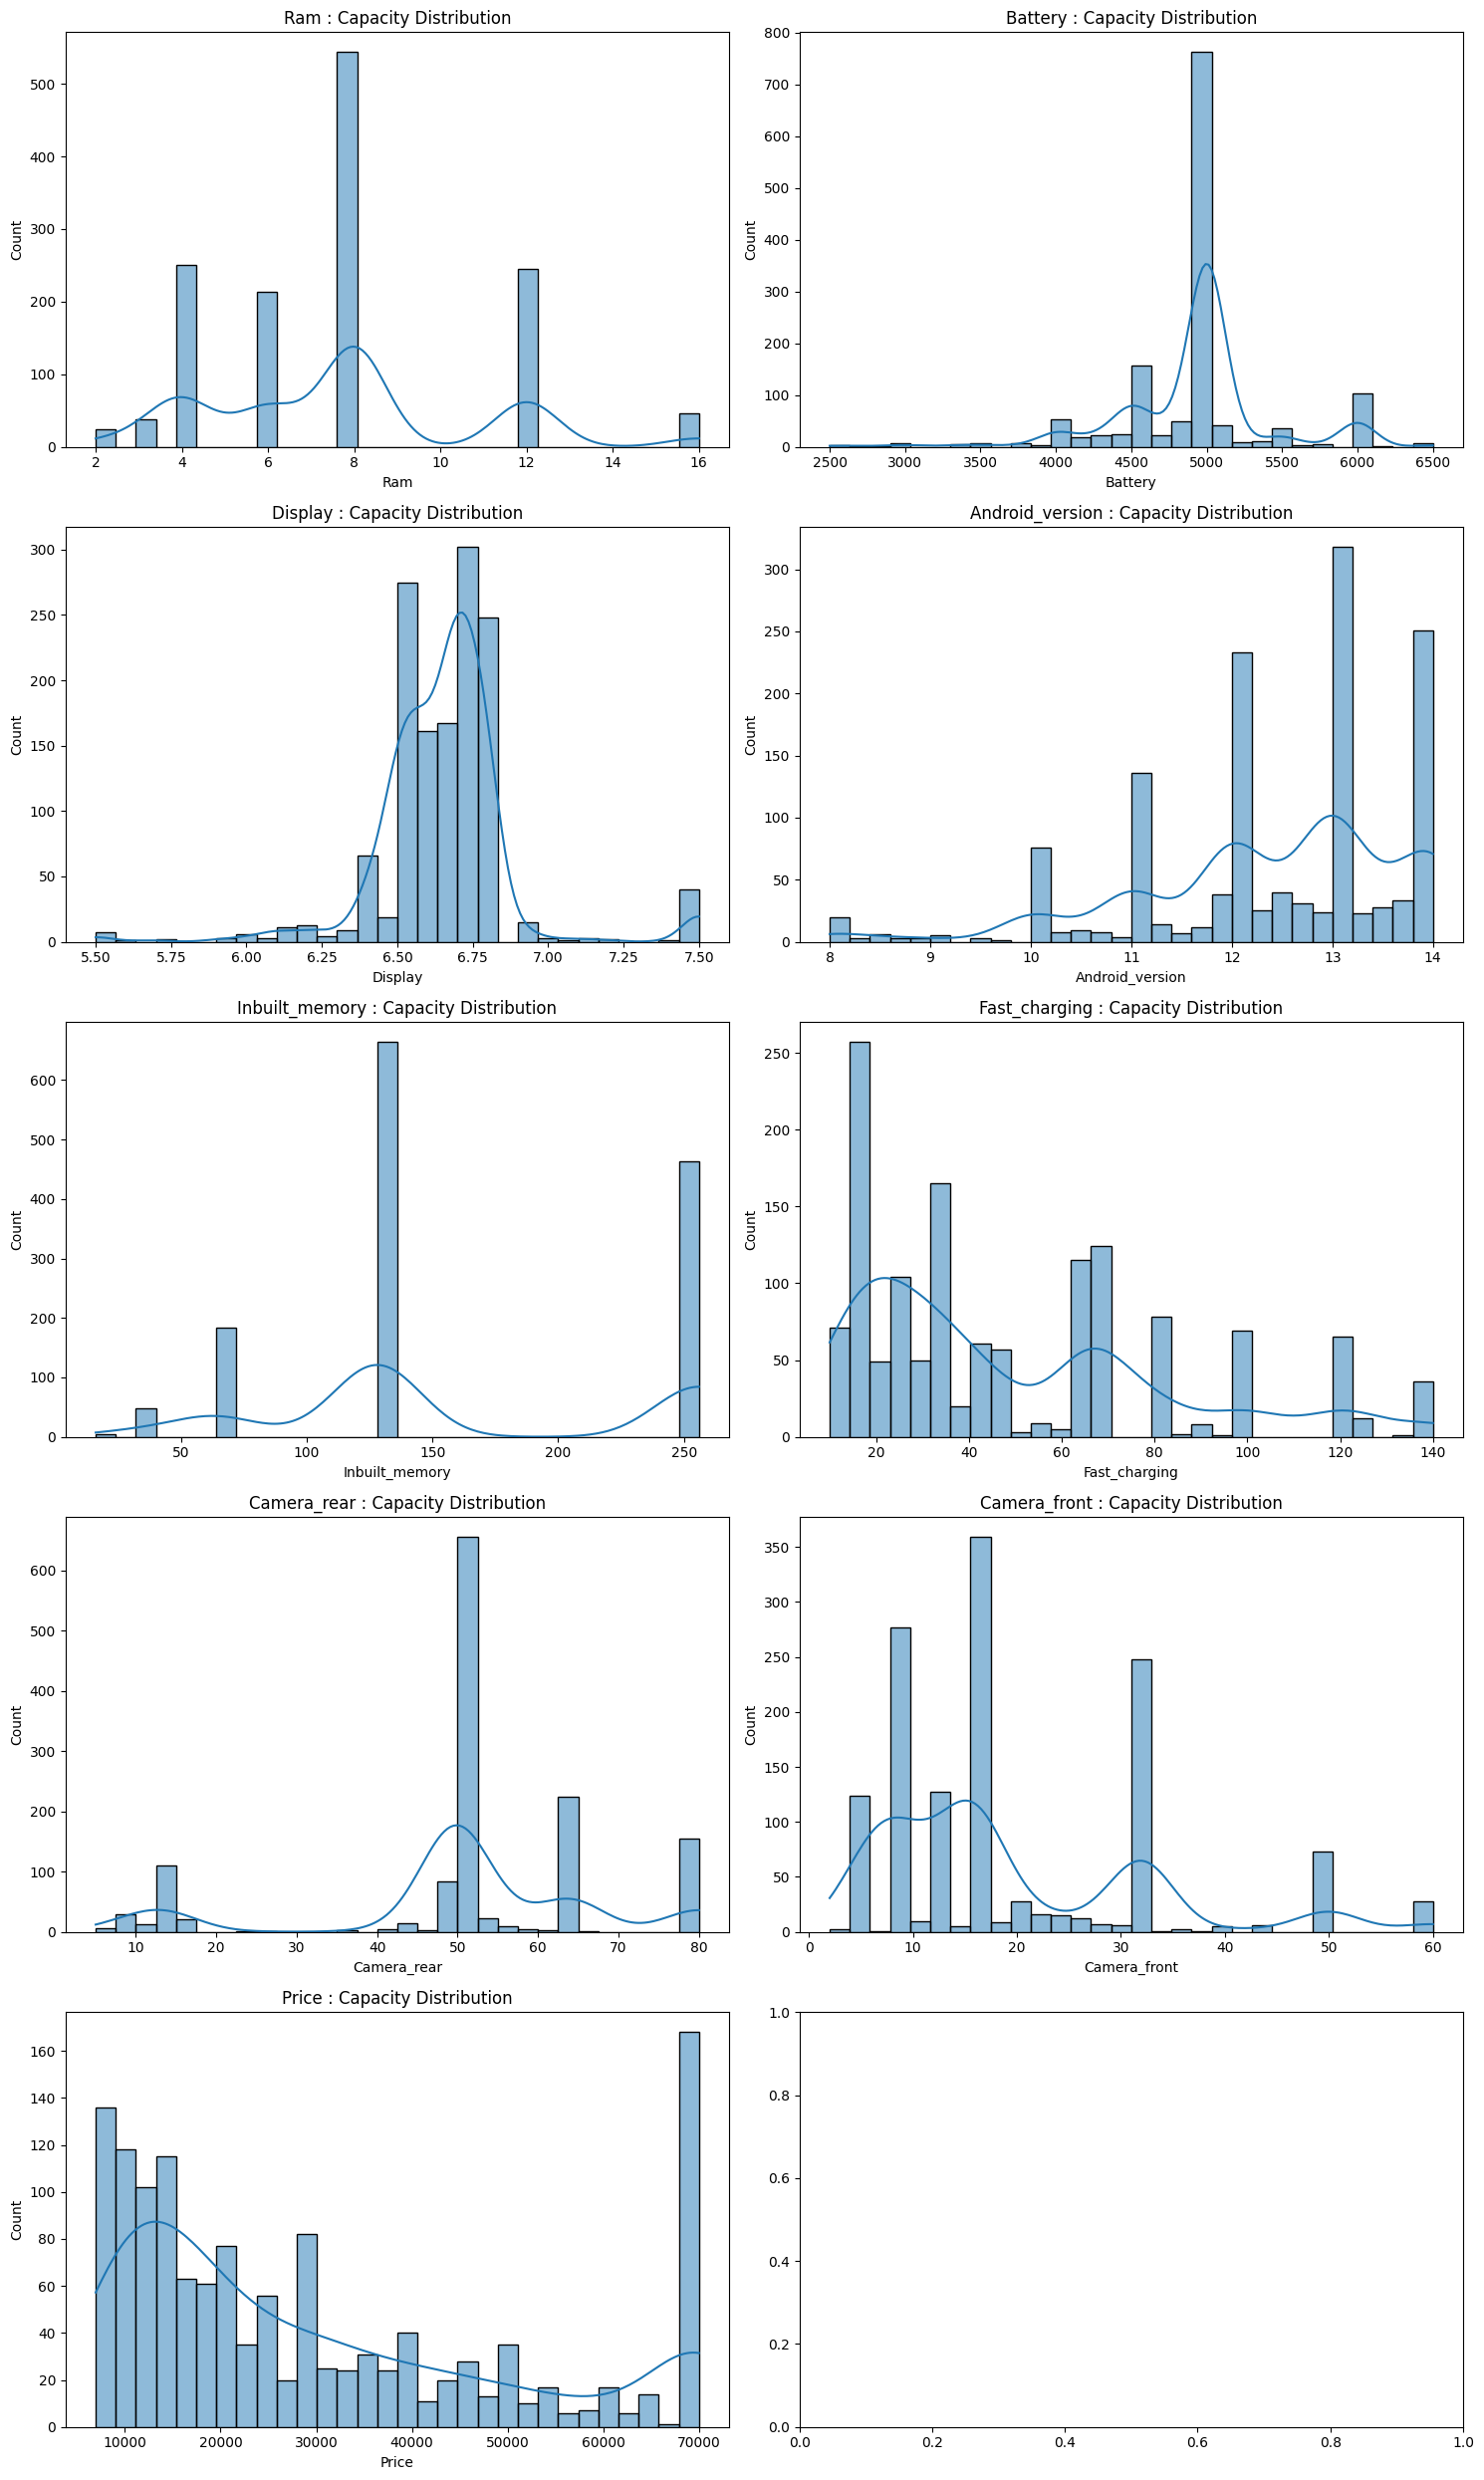

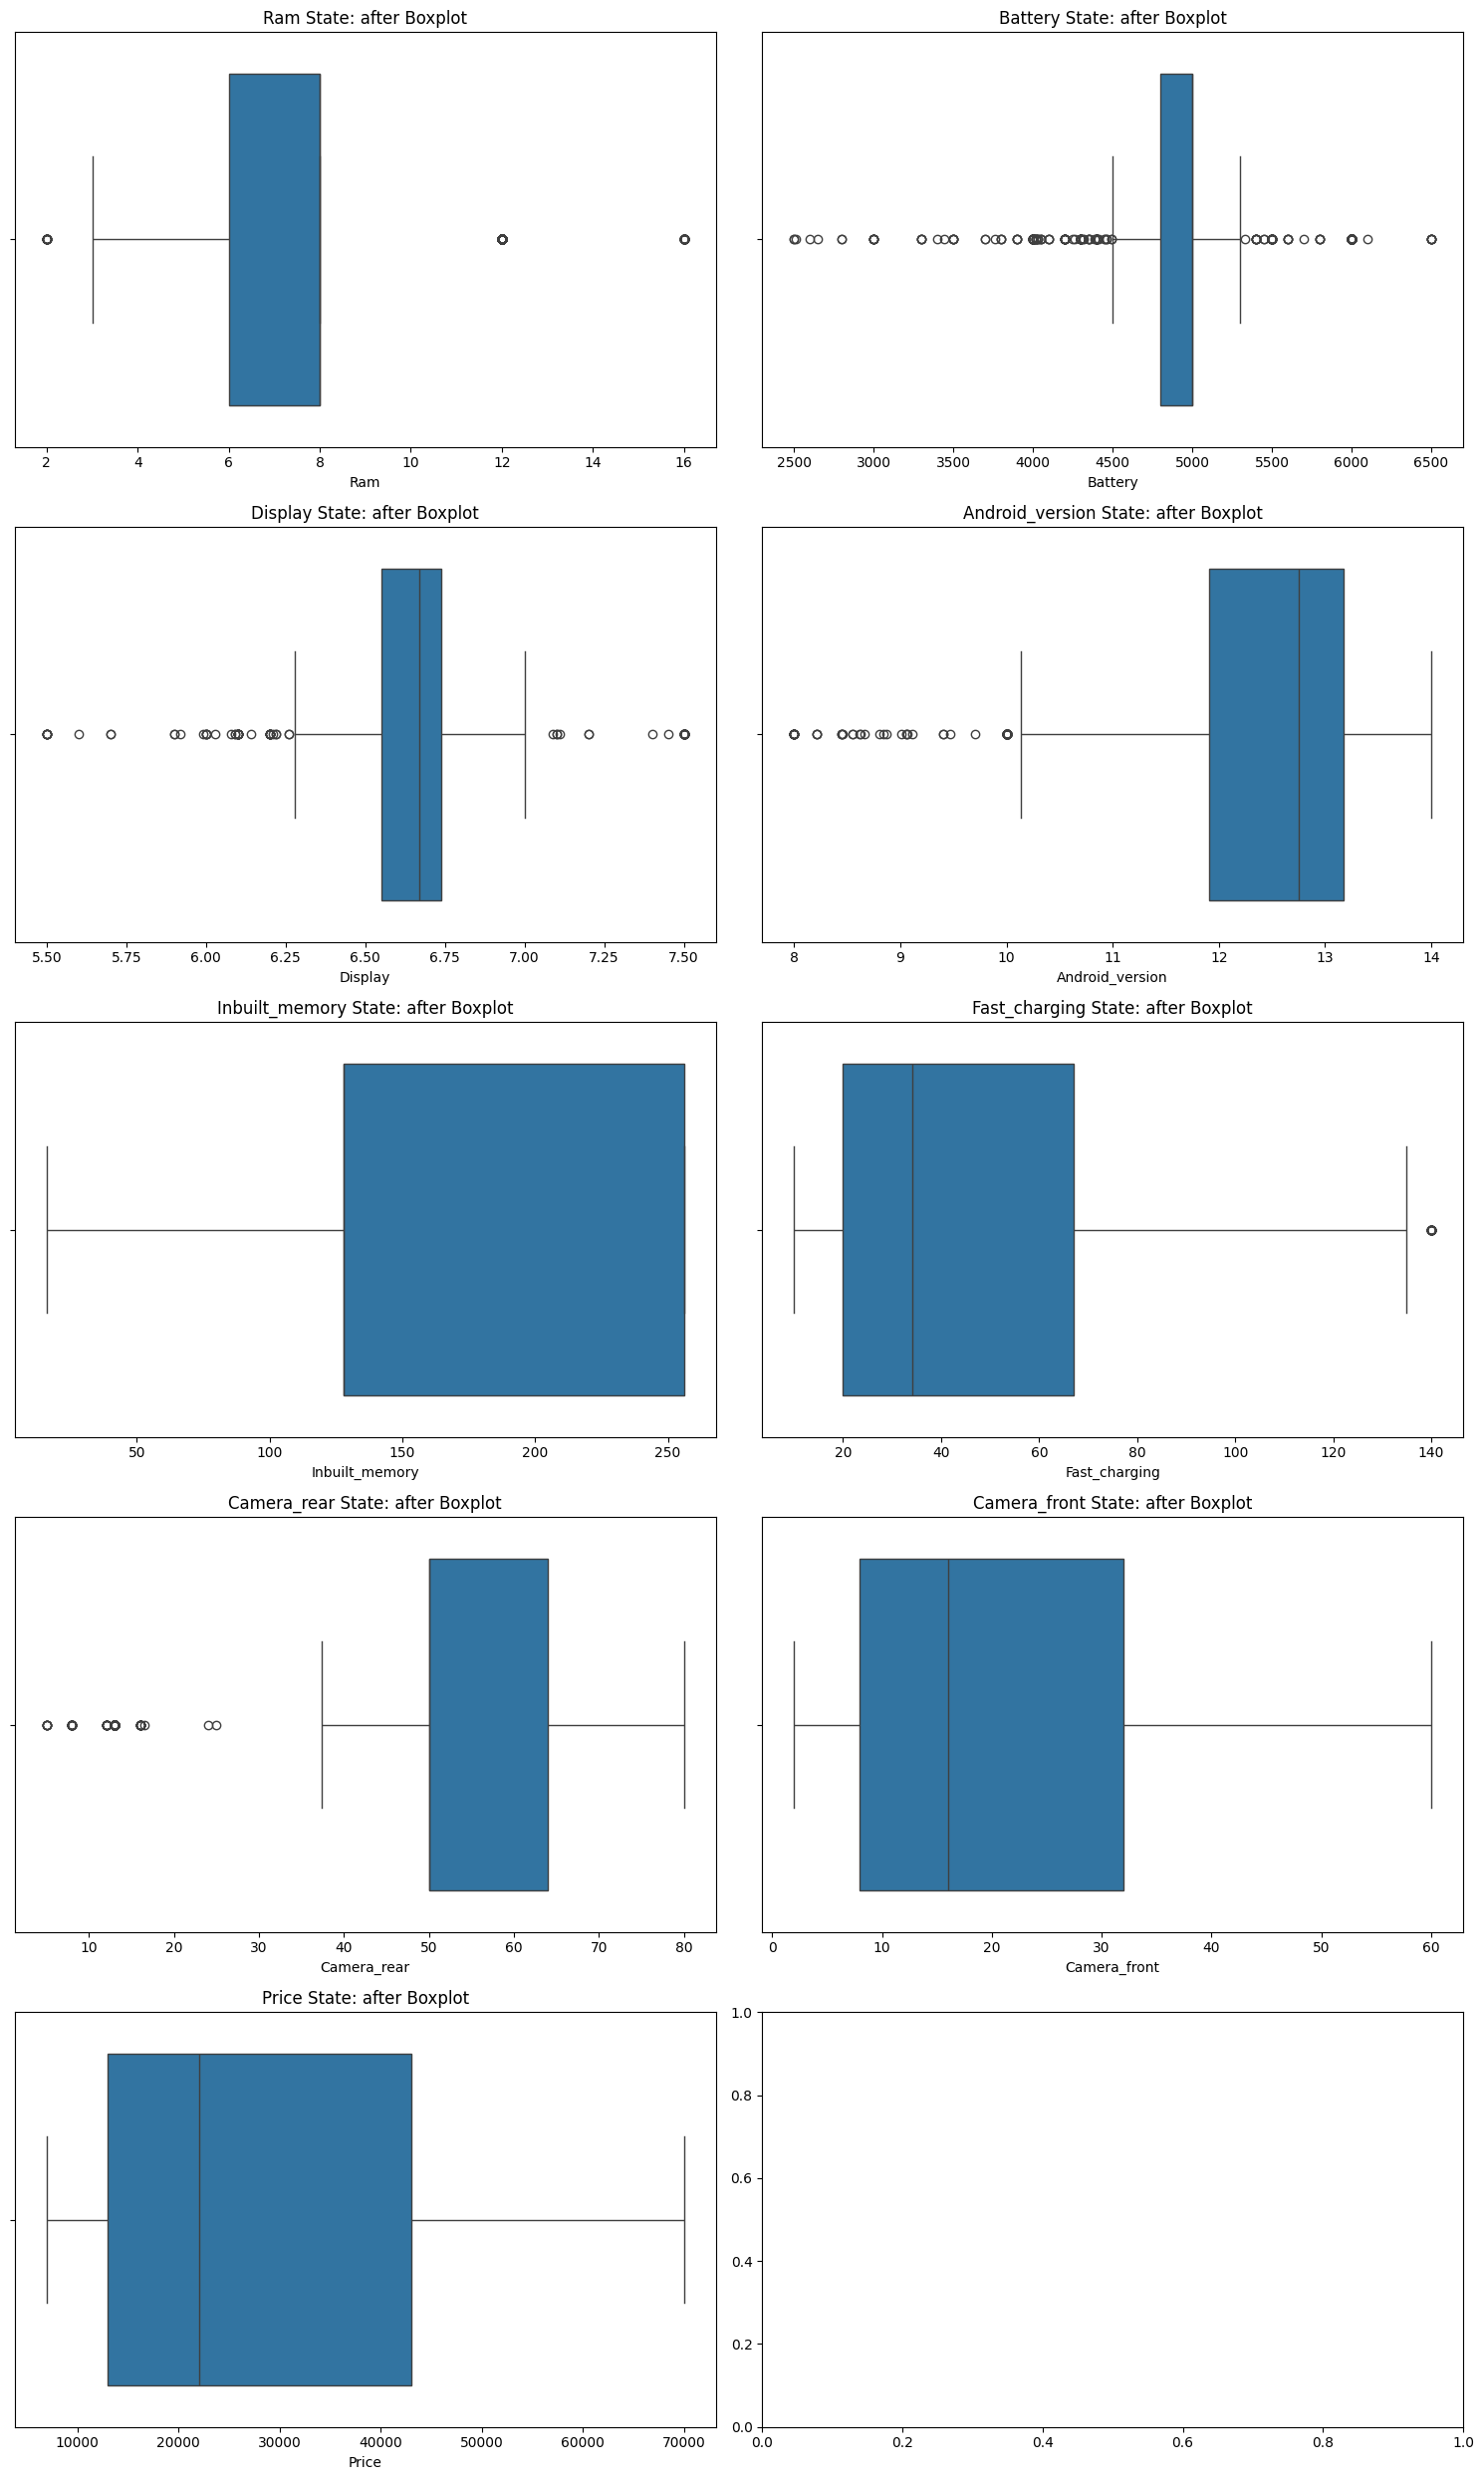

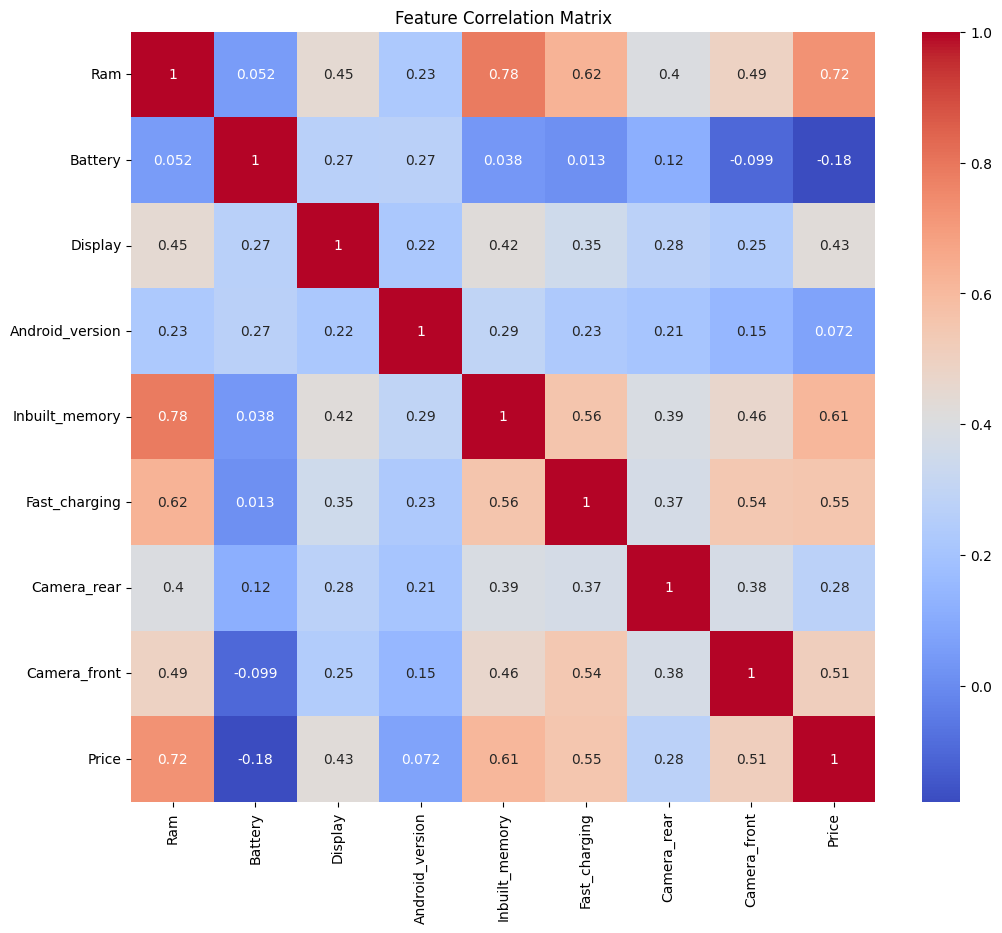

In [310]:
hist_plot_visualization(dataset_cleaned_encoded)
box_plot_visualization(dataset_cleaned_encoded,'after')
heatmap_visualization(dataset_cleaned_encoded)

In [311]:
X = dataset_cleaned_encoded.drop(target_column,axis=1)
y = dataset_cleaned_encoded.loc[:,target_column]

In [312]:
results_df = train_evaluate_with_gridsearch(X, y, models, param_grids)
results_df.to_csv('grid_search_results.csv',index=False)

In [313]:
# iterate over all rows and print the value of each column in the rows
for _, row in results_df.iterrows():
    for column in results_df.columns:
        # rounding the value in case of float number 
        if isinstance(row[column], float):
            print(f"{column}: {row[column]:.4f}")
        else:
            print(f"{column}: {row[column]}")
    print("\n")

model_name: Linear
model: Pipeline(steps=[('poly', PolynomialFeatures(degree=1)),
                ('scaler', StandardScaler()), ('model', LinearRegression())])
K_cv: 8
best_params: {'model__fit_intercept': True, 'poly__degree': 1}
best_r2: -6917928733488902569984.0000
train_time: 20.8247


model_name: Lasso
model: Pipeline(steps=[('scaler', StandardScaler()),
                ('model', Lasso(alpha=15, max_iter=10000, tol=0.1))])
K_cv: 8
best_params: {'model__alpha': 15, 'model__max_iter': 10000, 'model__tol': 0.1}
best_r2: 0.7445
train_time: 5.5027


model_name: Ridge
model: Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 Ridge(alpha=14, max_iter=30000, solver='saga', tol=0.01))])
K_cv: 8
best_params: {'model__alpha': 14, 'model__max_iter': 30000, 'model__solver': 'saga', 'model__tol': 0.01}
best_r2: 0.7458
train_time: 6.0571




In [314]:
best_model = results_df.loc[results_df['best_r2'].idxmax()]
save_model(best_model,'yes')

Model saved as: Ridge_model_k8_r2_0.746.joblib


In [315]:
input_data =pd.DataFrame({
    'Ram': [4,6,6],
    'Battery': [5100,5000,6000],
    'Display': [6.67,6.71,6.5],
    'Android_version': [14,12,14],
    'Inbuilt_memory': [128,128,128],
    'Fast_charging': [45,15,25],
    'Camera_rear': [8,50,50],
    'Camera_front': [5,5,13],
    'Processor_core': ["octa core","octa core","octa core"],
    'Company': ["oppo","poco","samsung"],
    'Processor_name': ["dimensity","helio","dimensity"]
    })
real_prices = [13500,11000,14500]

In [316]:
for file in os.listdir(os.getcwd()):
    if file.endswith('.joblib'):
        model_path = os.path.join(os.getcwd(),file)
print(model_path)

c:\Users\Acno_Sama\Desktop\university\Master\Complexity\project_tp\Ridge_model_k8_r2_0.746.joblib


In [317]:
best_model = joblib.load(model_path)

predict_price(input_data, real_prices, best_model, X, lower_bound, upper_bound)

The predicted price of the phone is: 16482.16
Difference in price: 2982
The predicted price of the phone is: 11288.26
Difference in price: 288
The predicted price of the phone is: 9710.56
Difference in price: -4790


Ridge_model_k8_r2_0.746.joblib :

The predicted price of the phone is: 16430.34
Difference in price: 2930
The predicted price of the phone is: 11269.62
Difference in price: 269
The predicted price of the phone is: 9684.67
Difference in price: -4816

---

